# Homework 3: Supervised Learning

## Exercise 1: Logistic Regression on a Toy 2D Dataset

1. Generate two Gaussian clusters in $\mathbb{R}^2$ and associate them with a class depending on which cluster each point lies on, e.g.:
   - Class 0 centered at $(-2, -2)$ with variance $1$,
   - Class 1 centered at $(2, 2)$ with variance $0.5$.
2. Plot the dataset in 2D using `plt.scatter` so that each cluster is colored according to its class.

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


rng = np.random.default_rng(211)

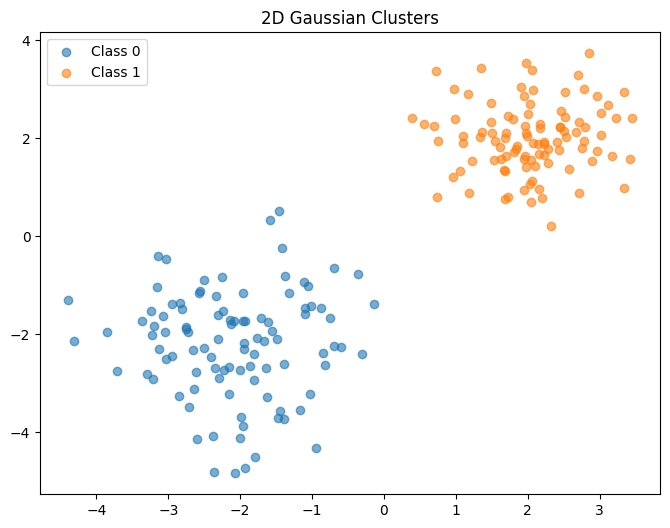

In [94]:
cluster_0 = rng.normal(loc=np.array([-2, -2]), scale=1.0, size=(100, 2))
cluster_1 = rng.normal(loc=np.array([2, 2]), scale=np.sqrt(0.5), size=(100, 2))

plt.figure(figsize=(8, 6))
plt.scatter(cluster_0[:, 0], cluster_0[:, 1], label='Class 0', alpha=0.6)
plt.scatter(cluster_1[:, 0], cluster_1[:, 1], label='Class 1', alpha=0.6)
plt.title('2D Gaussian Clusters')
plt.legend()
plt.show()

3. Implement logistic regression **from scratch** as did during class:
   
   $$
   f_\Theta(x) = \sigma(\Theta^T x),
   \qquad 
   \ell(\Theta; x,y)= -\big[y\log f_\Theta(x) + (1-y)\log(1 - f_\Theta(x))\big].
   $$

SGD accuracy: 100.00%
theta_sgd(theta_0, theta_1, theta_bias): [0.16620525 0.16829109 0.00051412]


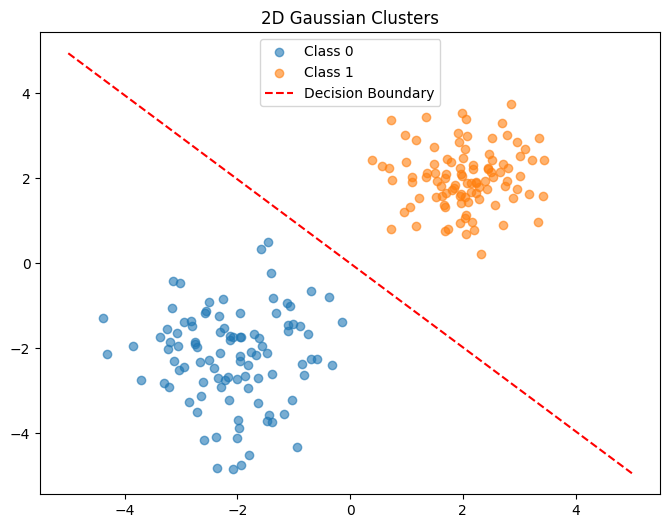

In [95]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def bce_loss(theta, x, y):
    p = sigmoid(x @ theta)
    # Binary Cross Entropy Loss
    return -(y*np.log(p) + (1-y)*np.log(1-p)).mean()

def grad_bce_loss(theta, x, y):
    # Gradient of bce loss
    return (x.T @ (sigmoid(x @ theta) - y)) / len(y)

def accuracy(theta, x, y):
    preds = sigmoid(x @ theta) >= 0.5
    return (preds == y).mean()

def train_sgd(l, grad_l, x, y, lr=0.1, epochs=200, batch_size=32, full_loss=False):
    N, d = x.shape
    theta = np.zeros((d, 1))
    losses, accs = [], []

    for epoch in range(epochs):
        # Shuffle data
        idx = np.arange(len(x))
        rng.shuffle(idx)

        x_shuffled = x[idx, :]
        y_shuffled = y[idx]

        for batch in range(0, N, batch_size):
            grad = grad_l(theta,
                             x_shuffled[batch:batch + batch_size, :],
                             y_shuffled[batch:batch + batch_size, :])
            theta -= lr * grad

        if full_loss:
            # Log full-dataset metrics after the epoch
            losses.append(l(theta, x, y))
            accs.append(accuracy(theta, x, y))
        else:
            # Log mini-batch metrics after the epoch
            losses.append(l(theta,
                             x_shuffled[0:batch_size, :],
                             y_shuffled[0:batch_size, :]))
            accs.append(accuracy(theta,
                                 x_shuffled[0:batch_size, :],
                                 y_shuffled[0:batch_size, :]))

    return theta, np.array(losses), np.array(accs)

X = np.hstack((np.vstack((cluster_0, cluster_1)), np.ones((200, 1))))
y = np.hstack((np.zeros(cluster_0.shape[0]), np.ones(cluster_1.shape[0]))).reshape(-1, 1)

theta_sgd, loss_sgd, acc_sgd = train_sgd(bce_loss, grad_bce_loss, X, y,
                                         lr=1e-3, epochs=200, batch_size=200)
print(f"SGD accuracy: {acc_sgd[-1]*100:.2f}%")
print(f"theta_sgd(theta_0, theta_1, theta_bias): {theta_sgd.ravel()}")
plt.figure(figsize=(8, 6))
plt.scatter(cluster_0[:, 0], cluster_0[:, 1], label='Class 0', alpha=0.6)
plt.scatter(cluster_1[:, 0], cluster_1[:, 1], label='Class 1', alpha=0.6)

x0_values = np.array([-5, 5])
x1_values = -(theta_sgd[2] + theta_sgd[0] * x0_values) / theta_sgd[1]
plt.plot(x0_values, x1_values, 'r--', label='Decision Boundary')

plt.title('2D Gaussian Clusters')
plt.legend()
plt.show()


## Exercise 2: SGD on Logistic Regression

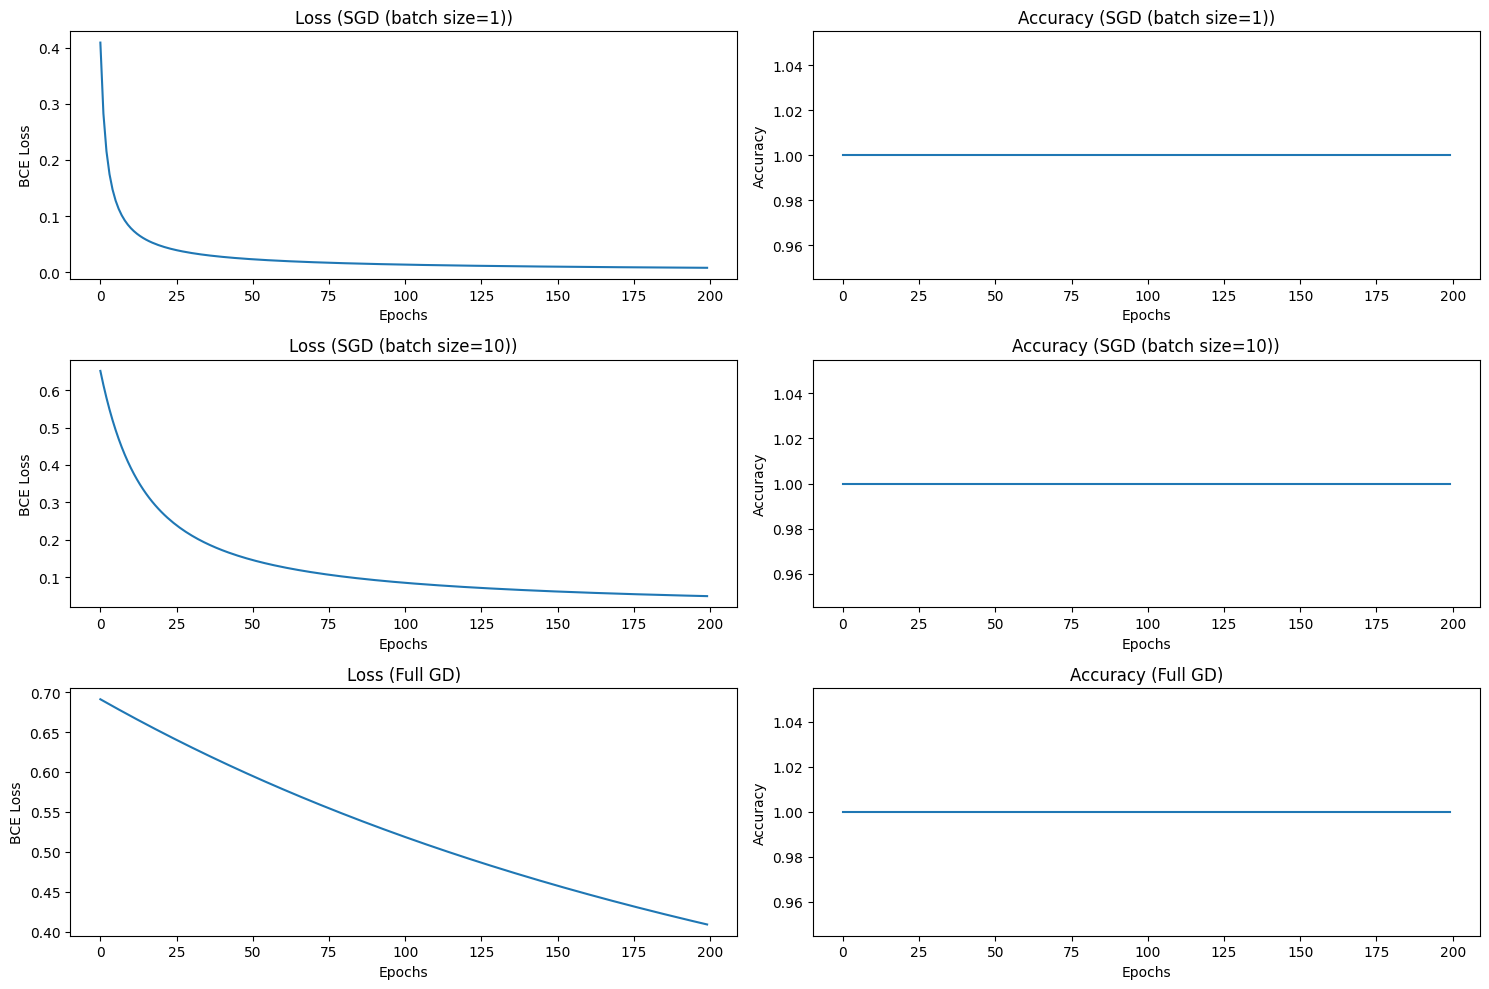

In [96]:
batch_sizes = [1, 10, 200]

fig, axs = plt.subplots(3, 2, figsize=(3*5, 2*5))

for i, batch_size in enumerate(batch_sizes):
    if batch_size == 200:
        title = "Full GD"
    else:
        title = f"SGD (batch size={batch_size})"
    theta_sgd, loss_sgd, acc_sgd = train_sgd(bce_loss, grad_bce_loss, X, y,
                                             lr=1e-3, epochs=200, batch_size=batch_size, full_loss=True)
    axs[i, 0].plot(loss_sgd)
    axs[i, 0].set_title(f'Loss ({title})')
    axs[i, 0].set_xlabel('Epochs')
    axs[i, 0].set_ylabel('BCE Loss')

    axs[i, 1].plot(acc_sgd)
    axs[i, 1].set_title(f'Accuracy ({title})')
    axs[i, 1].set_xlabel('Epochs')
    axs[i, 1].set_ylabel('Accuracy')


plt.tight_layout()
plt.show()

## Exercise 3: Evaluation Metrics on a Synthetic Dataset

In [ ]:
def evaluate_metrics(theta, X, y, threshold):
    y_prob = sigmoid(X @ theta)
    y_pred = (y_prob >= threshold).astype(int)

    # Confusion Matrix Elements
    TP = np.sum((y_pred == 1) & (y == 1))
    TN = np.sum((y_pred == 0) & (y == 0))
    FP = np.sum((y_pred == 1) & (y == 0))
    FN = np.sum((y_pred == 0) & (y == 1))
    accuracy = (TP + TN) / len(y)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "Threshold": threshold,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "Conf Matrix": [[TP, FP], [FN, TN]] # [[Pred Pos/Act Pos, Pred Pos/Act Neg], ...]
    }

def print_confusion_matrix(conf_matrix):
    print("Confusion Matrix:")
    print(f"                    Predicted Positive   Predicted Negative")
    print(f"Actual Positive      {conf_matrix[0][0]}                  {conf_matrix[1][0]}")
    print(f"Actual Negative      {conf_matrix[0][1]}                  {conf_matrix[1][1]}")

# Use the theta from Ex 1
thresholds = [0.3, 0.5, 0.7]
results = []
for t in thresholds:
    results.append(evaluate_metrics(theta_sgd, X, y, t))

results_df = pd.DataFrame(results)
print(results_df[["Threshold", "Accuracy", "Precision", "Recall", "F1"]])
print()
print("thresholds = 0.3")
print_confusion_matrix(results[0]["Conf Matrix"])
print()
print("thresholds = 0.5")
print_confusion_matrix(results[1]["Conf Matrix"])
print()
print("thresholds = 0.7")
print_confusion_matrix(results[2]["Conf Matrix"])

   Threshold  Accuracy  Precision  Recall        F1
0        0.3     0.645   0.584795    1.00  0.738007
1        0.5     1.000   1.000000    1.00  1.000000
2        0.7     0.565   1.000000    0.13  0.230088

thresholds = 0.3
Confusion Matrix:
                    Predicted Positive   Predicted Negative
Actual Positive      100                  0
Actual Negative      71                  29

thresholds = 0.5
Confusion Matrix:
                    Predicted Positive   Predicted Negative
Actual Positive      100                  0
Actual Negative      0                  100

thresholds = 0.7
Confusion Matrix:
                    Predicted Positive   Predicted Negative
Actual Positive      13                  87
Actual Negative      0                  100


## Exercise 4: Logistic Regression on a Real Dataset

In [99]:
df = pd.read_csv("diabetes.csv")

x = df.drop(columns=["Outcome"]).values
y_outcome = df["Outcome"].values.reshape(-1, 1)

x_mean = x.mean(axis=0)
x_std = x.std(axis=0)
x_norm = (x - x_mean) / x_std

x_features = np.hstack((x_norm, np.ones((x_norm.shape[0], 1))))
N, d = x_features.shape

Optimize using SGD:

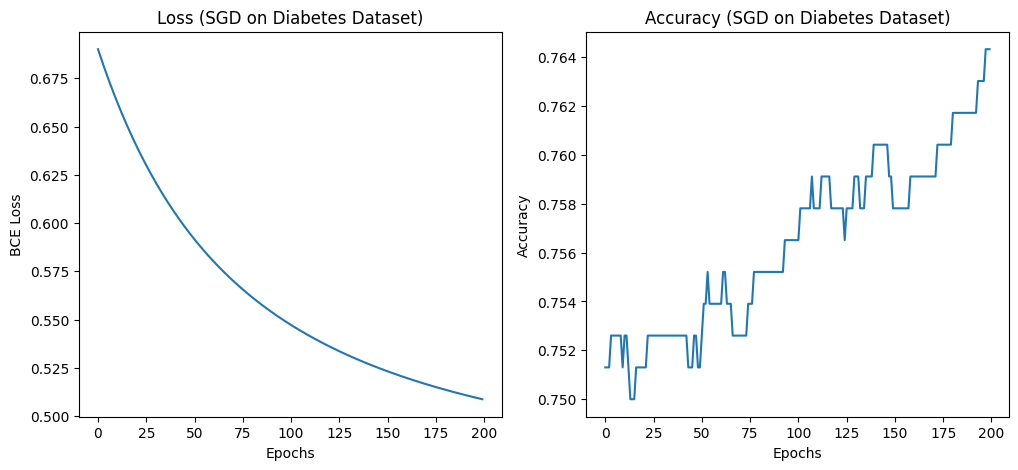

Final accuracy on Diabetes Dataset: 76.43%


In [100]:
theta_sgd, loss_sgd, acc_sgd = train_sgd(bce_loss, grad_bce_loss, x_features, y_outcome,
                                         lr=1e-3, epochs=200, batch_size=32, full_loss=True)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(loss_sgd)
axs[0].set_title('Loss (SGD on Diabetes Dataset)')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('BCE Loss')
axs[1].plot(acc_sgd)
axs[1].set_title('Accuracy (SGD on Diabetes Dataset)')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
plt.show()

print(f"Final accuracy on Diabetes Dataset: {acc_sgd[-1]*100:.2f}%")

Train with Adam:

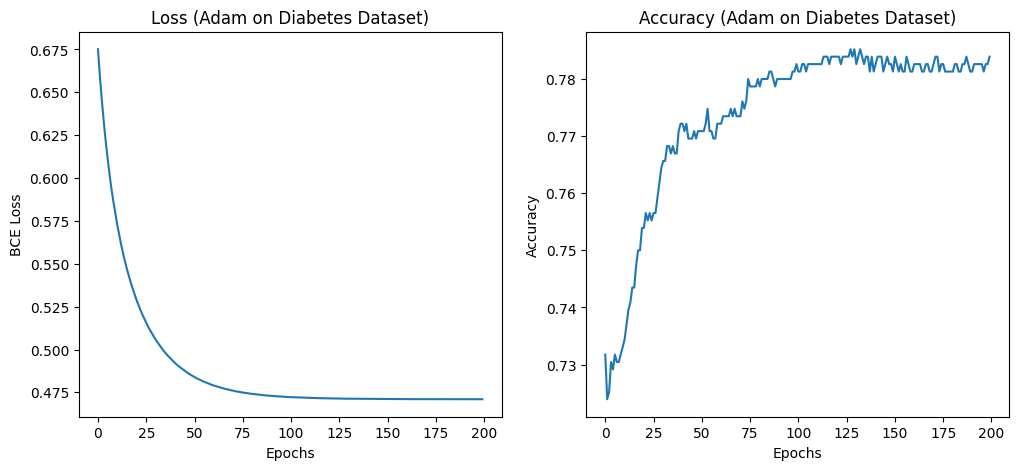

Adam accuracy: 78.39%


In [101]:
def train_adam(l, grad_l, X, y, lr=1e-3, epochs=200, batch_size=32,
beta1=0.9, beta2=0.999, eps=1e-8,
):
    N, d = X.shape
    theta = np.zeros((d, 1))
    m = np.zeros_like(theta)
    v = np.zeros_like(theta)
    t = 0

    losses, accs = [], []

    for epoch in range(epochs):
        # Shuffle data
        idx = np.arange(len(X))
        np.random.shuffle(idx)

        x_shuffled = X[idx, :]
        y_shuffled = y[idx]
        for batch in range(0, N, batch_size):
            g = grad_l(theta, x_shuffled[batch:batch + batch_size], y_shuffled[batch:batch + batch_size])

            t += 1
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * (g * g)
            m_hat = m / (1 - beta1 ** t)
            v_hat = v / (1 - beta2 ** t)

            theta -= lr * (m_hat / (np.sqrt(v_hat) + eps))

        # Log full-dataset metrics after the epoch
        losses.append(l(theta, X, y))
        accs.append(accuracy(theta, X, y))

    return theta, np.array(losses), np.array(accs)

theta_adam, loss_adam, acc_adam = train_adam(bce_loss, grad_bce_loss, x_features, y_outcome,
                                             lr=1e-3, epochs=200, batch_size=32)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(loss_adam)
axs[0].set_title('Loss (Adam on Diabetes Dataset)')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('BCE Loss')
axs[1].plot(acc_adam)
axs[1].set_title('Accuracy (Adam on Diabetes Dataset)')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
plt.show()

print(f"Adam accuracy: {acc_adam[-1]*100:.2f}%")

In [102]:
results_ex4 = []
results_ex4.extend([
    evaluate_metrics(theta_sgd, x_features, y_outcome, threshold=0.5),
    evaluate_metrics(theta_adam, x_features, y_outcome, threshold=0.5),
])
results_df = pd.DataFrame(results_ex4)
print(results_df[["Threshold", "Accuracy", "Precision", "Recall", "F1"]])
print()
print("SGD")
print_confusion_matrix(results_ex4[0]["Conf Matrix"])
print()
print("Adam")
print_confusion_matrix(results_ex4[1]["Conf Matrix"])
print()


   Threshold  Accuracy  Precision    Recall        F1
0        0.5  0.764323   0.688312  0.593284  0.637275
1        0.5  0.783854   0.740566  0.585821  0.654167

SGD
Confusion Matrix:
                    Predicted Positive   Predicted Negative
Actual Positive      159                  109
Actual Negative      72                  428

Adam
Confusion Matrix:
                    Predicted Positive   Predicted Negative
Actual Positive      157                  111
Actual Negative      55                  445



### Optional Extension: From Logistic Regression to a Simple Neural Network

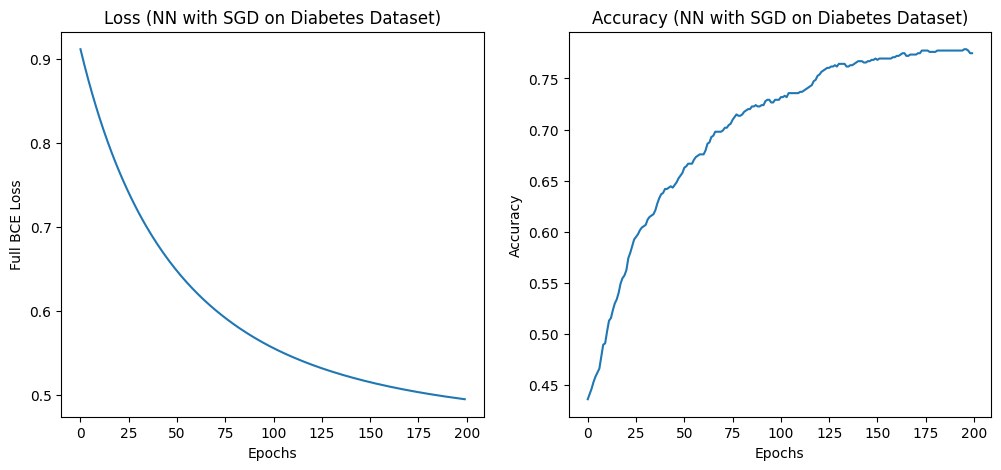

Neural Network final accuracy: 77.47%


In [103]:
def relu(z):
    return np.maximum(0, z)

def relu_grad(z):
    g = np.zeros_like(z)
    g[z > 0] = 1.0
    return g

def bce_loss(y_hat, y, eps=1e-10):
    y_hat = np.clip(y_hat, eps, 1 - eps)
    return -(y*np.log(y_hat) + (1-y)*np.log(1 - y_hat)).mean()

def train_nn_sgd(X, y, hidden=16, lr=1e-2, epochs=200, batch_size=32):
    N, d = X.shape

    W1 = np.random.normal(0, np.sqrt(2/d), size=(d, hidden))
    b1 = np.zeros((1, hidden))
    W2 = np.random.normal(0, np.sqrt(2/hidden), size=(hidden, 1))
    b2 = np.zeros((1, 1))

    losses, accs = [], []

    for _ in range(epochs):
        # Shuffle data
        idx = np.arange(len(X))
        rng.shuffle(idx)

        X_shuffled = X[idx, :]
        y_shuffled = y[idx]

        for batch in range(0, N, batch_size):
            Xb, yb = X_shuffled[batch:batch+batch_size], y_shuffled[batch:batch+batch_size]
            # forward
            z1 = Xb @ W1 + b1
            a1 = relu(z1)
            z2 = a1 @ W2 + b2
            y_hat = sigmoid(z2)

            # backward
            delta2 = (y_hat - yb) / len(yb)
            dW2 = a1.T @ delta2
            db2 = delta2.sum(axis=0, keepdims=True)

            delta1 = (delta2 @ W2.T) * relu_grad(z1)
            dW1 = Xb.T @ delta1
            db1 = delta1.sum(axis=0, keepdims=True)

            # update
            W1 -= lr * dW1
            b1 -= lr * db1
            W2 -= lr * dW2
            b2 -= lr * db2

        # track
        z1 = X @ W1 + b1
        a1 = relu(z1)
        z2 = a1 @ W2 + b2
        yhat_full = sigmoid(z2)

        # full loss
        losses.append(bce_loss(yhat_full, y))
        preds = (yhat_full >= 0.5).astype(int)
        accs.append((preds == y).mean())

    return (W1, b1, W2, b2), np.array(losses), np.array(accs)

theta_nn_sgd, loss_nn_sgd, acc_nn_sgd = train_nn_sgd(
    x_features, y_outcome,
    hidden=16,
    lr=1e-3,
    epochs=200,
    batch_size=32,
)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(loss_nn_sgd)
axs[0].set_title('Loss (NN with SGD on Diabetes Dataset)')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Full BCE Loss')
axs[1].plot(acc_nn_sgd)
axs[1].set_title('Accuracy (NN with SGD on Diabetes Dataset)')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
plt.show()


print(f"Neural Network final accuracy: {acc_nn_sgd[-1]*100:.2f}%")

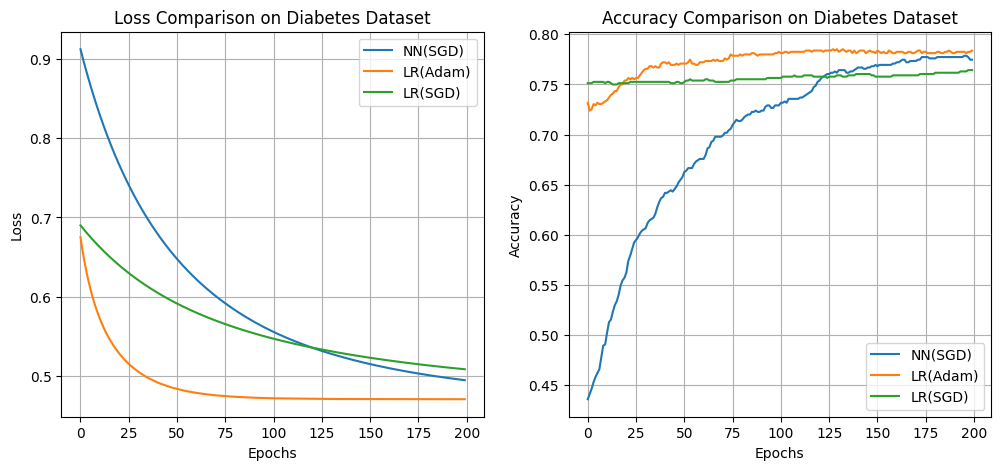

In [104]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(loss_nn_sgd, label="NN(SGD)")
axs[0].plot(loss_adam, label="LR(Adam)")
axs[0].plot(loss_sgd, label="LR(SGD)")
axs[0].set_title('Loss Comparison on Diabetes Dataset')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

axs[1].plot(acc_nn_sgd, label="NN(SGD)")
axs[1].plot(acc_adam, label="LR(Adam)")
axs[1].plot(acc_sgd, label="LR(SGD)")
axs[1].set_title('Accuracy Comparison on Diabetes Dataset')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid()
plt.show()